In [1]:
import pandas as pd
from tqdm import tqdm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle('football_model_processed.pickle')
df

# ==============================  
# SAME FEATURE SELECTION  
# ==============================
X = df.drop(columns = {
    'shot_outcome_encoded'
})
y = df['shot_outcome_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=123,
    stratify=y
)
X_train.shape, X_test.shape

((33888, 37), (11297, 37))

In [3]:
cont_cols = [
    col for col in X_train.columns
    if pd.api.types.is_numeric_dtype(X_train[col])       # numeric
    and X_train[col].nunique() > 2              # not binary
]

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[cont_cols] = scaler.fit_transform(X_train[cont_cols])

X_test_scaled = X_test.copy()
X_test_scaled[cont_cols] = scaler.transform(X_test[cont_cols])

In [4]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# ----------------------------------------------------------
# 1) Clean, practical AdaBoost hyperparameter grid
# ----------------------------------------------------------
param_grid_ada = {
    'n_estimators': [200, 400, 600],          # stronger range for boosting
    'learning_rate': [0.01, 0.05, 0.1],       # key parameter for boosting stability

    # Base learner complexity (affects variance)
    'estimator__max_depth': [1, 2, 3],        # stumps (1) → classic AdaBoost
    'estimator__min_samples_split': [2, 5, 10]
}

# ----------------------------------------------------------
# 2) Base estimator (no class_weight)
# ----------------------------------------------------------
base_tree = DecisionTreeClassifier(
    random_state=123
)

# ----------------------------------------------------------
# 3) AdaBoost model
# ----------------------------------------------------------
ada = AdaBoostClassifier(
    estimator=base_tree,
    random_state=123
)

# ----------------------------------------------------------
# 4) Grid search
# ----------------------------------------------------------
grid_search_ada = GridSearchCV(
    estimator=ada,
    param_grid=param_grid_ada,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)

print("Starting GridSearchCV...")
grid_search_ada.fit(X_train_scaled, y_train)
print("Grid search completed.")

print("\nBest parameters:", grid_search_ada.best_params_)
print("Best cross-validated AUC:", grid_search_ada.best_score_)



Starting GridSearchCV...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Grid search completed.

Best parameters: {'estimator__max_depth': 3, 'estimator__min_samples_split': 5, 'learning_rate': 0.1, 'n_estimators': 600}
Best cross-validated AUC: 0.8055827017744495


In [5]:
best_model = grid_search_ada.best_estimator_


Test Set Performance (AdaBoost):

Test AUC: 0.7984

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     10216
           1       0.71      0.10      0.18      1081

    accuracy                           0.91     11297
   macro avg       0.81      0.55      0.56     11297
weighted avg       0.89      0.91      0.88     11297


Confusion Matrix:
[[10172    44]
 [  973   108]]


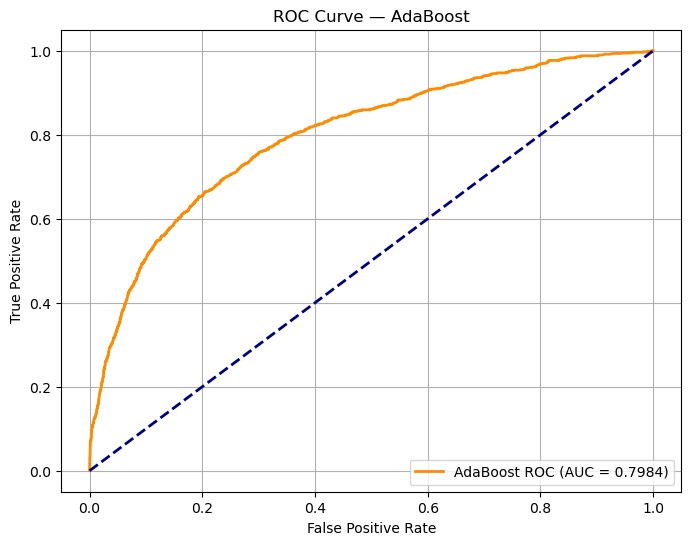

In [6]:
print("\n" + "="*50)
print("Test Set Performance (AdaBoost):")
print("="*50)

y_test_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
y_test_pred = best_model.predict(X_test_scaled)

test_auc = roc_auc_score(y_test, y_test_pred_proba)
print(f"\nTest AUC: {test_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AdaBoost ROC (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — AdaBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


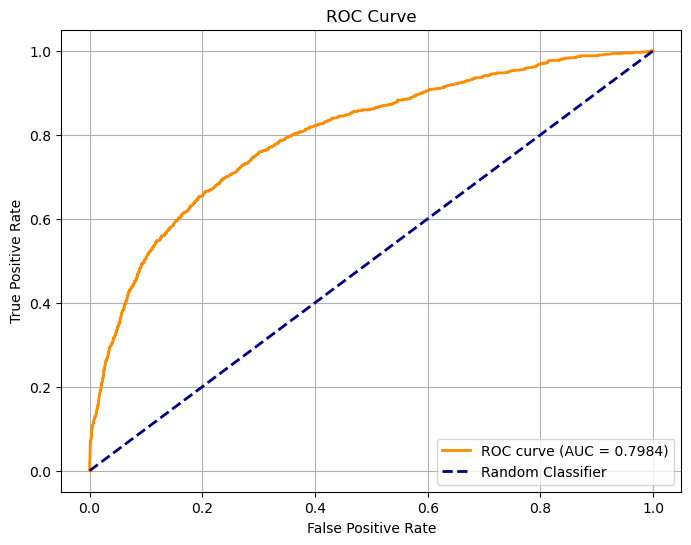

In [7]:
# draw roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [11]:
y_test_cal = pd.DataFrame({
    'shot_outcome_encoded': y_test,
    'predictions': y_test_pred_proba
})
y_test_cal

,shot_outcome_encoded,predictions
6457,1,0.269842
24146,0,0.190173
11254,0,0.168774
8245,0,0.241663
44143,1,0.582105
...,...,...
34990,0,0.121595
9423,0,0.224377
17105,0,0.199685
29910,0,0.306596


In [12]:
import numpy as np
## Drawing calibration curve
model_probs = np.linspace(0.05, 0.95, num=10)
true_probs = []

for prob in model_probs:
    true_probs.append(y_test_cal[(y_test_cal.predictions >= prob-0.05)
                                 & (y_test_cal.predictions <= prob+0.05)]['shot_outcome_encoded'].mean())

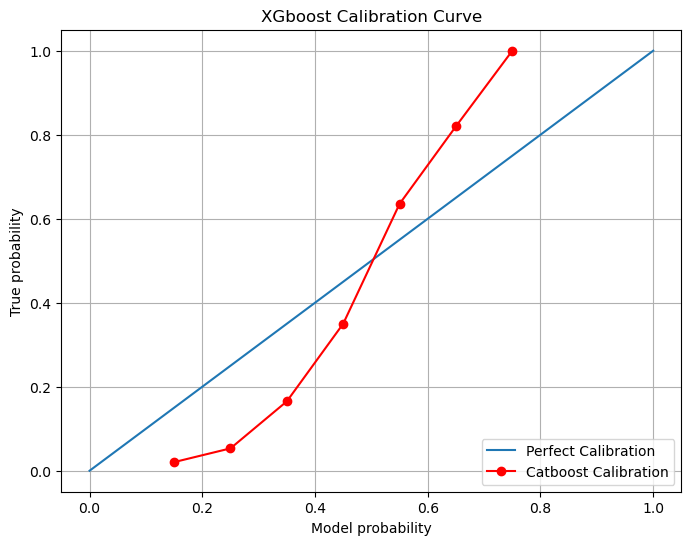

In [13]:
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], label="Perfect Calibration")
plt.plot(model_probs, true_probs, color='red', marker='o', label="Catboost Calibration")

plt.xlabel('Model probability')
plt.ylabel('True probability')
plt.title('XGboost Calibration Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
